# Decision Boundary

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

The objective is to accept the highest possible number of operations with minimum default rate. To conduct this analysis a number of acceptances rates are going to be calculated and their default rate.

**LGD** (Loss Given Default) weren't calculated, so isn't possible to measure the impact on accepting a loan that eventualy will turn a default one. 

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from catboost import CatBoostClassifier, Pool

from catboost.utils import get_roc_curve, get_fpr_curve, get_fnr_curve

In [3]:

# Set Matplotlib defaults
plt.style.use("seaborn-ticks")
plt.rc("figure", autolayout=True,figsize=(7,5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


In [4]:
os.getcwd()

'/Users/mac/Documents/Python/CreditRisk/Notebooks'

In [5]:
os.chdir('/Users/mac/Documents/Python/CreditRisk')

In [6]:
#load the model

model = CatBoostClassifier()

model.load_model("Models/catboost_model_1.bin")

In [7]:
df_val = pd.read_csv('Data/df_val_clean.csv')

In [8]:
X_validation = df_val.copy()
y_validation = X_validation.pop('loan_status')

In [9]:
def feature_engineering(X):
    X_new = X.copy()
        
    X_new.drop('cb_person_cred_hist_length',axis=1,inplace=True)
    
    #person employed
    X_new.loc[X_new.person_emp_length==0,'employed'] = 'N'
    X_new.loc[X_new.person_emp_length >0,'employed'] = 'Y'
    
    #income médio por tipo de home ownership
    by_home_ownership = X_new.groupby('person_home_ownership')
    X_new['mean_income_homeown'] = by_home_ownership.person_income.transform(lambda x: x.mean()).round(2)

    #loan_intent
    by_loan_intent = X_new.groupby('loan_intent')
    X_new['mean_income_intent'] = by_loan_intent.person_income.transform(lambda x: x.mean()).round(2)

    #income médio por loan_grade
    by_loan_grade = X_new.groupby('loan_grade')
    X_new['mean_income_grade'] = by_loan_grade.person_income.transform(lambda x: x.mean()).round(2)

    #person_income/person_emp_lengthD
    X_new.loc[X_new.person_emp_length==0,'income_emp_length_ratio'] = 0
    X_new.loc[X_new.person_emp_length!=0,'income_emp_length_ratio'] = X_new.person_income / X_new.person_emp_length

    #Difference between person_income and loan_amnt
    X_new['income_loan_diff'] = X_new['person_income'] - X_new['loan_amnt']

    return X_new

In [10]:
X_validation = feature_engineering(X_validation)

In [11]:
cat_features = [col for col in X_validation.select_dtypes(['object'])]

In [12]:
validation_pool = Pool(X_validation,y_validation,cat_features=cat_features)

In [13]:
df_pred = pd.concat([y_validation,pd.Series(model.predict_proba(X_validation)[:,1],name='prob_default')],axis=1)

In [14]:
df_pred

,loan_status,prob_default
0,1,0.943088
1,0,0.053275
2,0,0.937162
3,0,0.122814
4,0,0.087836
...,...,...
6510,0,0.020695
6511,1,0.057811
6512,1,0.169471
6513,0,0.095337


In [15]:
# Check the statistics of the probabilities of default
print(df_pred['prob_default'].describe())

count    6515.000000
mean        0.231849
std         0.329274
min         0.000413
25%         0.036174
50%         0.076311
75%         0.215644
max         0.999971
Name: prob_default, dtype: float64


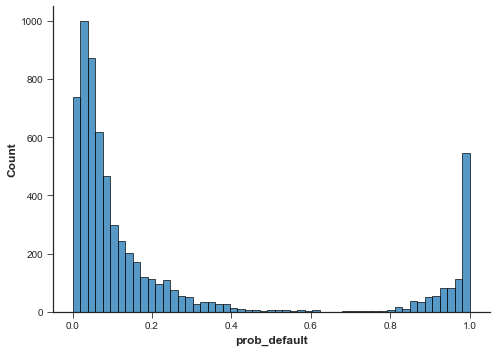

In [16]:
f,ax = plt.subplots(1,1)
sns.histplot(data=df_pred,x='prob_default',ax=ax)

threshold = np.quantile(df_pred['prob_default'], 0.80)



sns.despine()

In [30]:
accept_rates = np.arange(0.05,1,0.05)
thresholds=[]
bad_rates = []
num_accepted = []
estimated_value =[]

In [31]:

for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(df_pred['prob_default'], rate).round(3)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(df_pred['prob_default'], rate).round(3))
    
    # Reassign the loan_status value using the threshold
    df_pred['pred_loan_status'] = df_pred['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = df_pred[df_pred['pred_loan_status'] == 0]
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['loan_status']) / len(accepted_loans['loan_status'])).round(3))
    # Calculate and append the number os accepted loan
    num_accepted.append(len(accepted_loans['loan_status']))
    

In [32]:
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates,num_accepted),
                        columns = ['Acceptance Rate','Threshold','Bad Rate','Num Accepted Loans'])

In [33]:
strat_df.reset_index(drop=True)

,Acceptance Rate,Threshold,Bad Rate,Num Accepted Loans
0,0.05,0.011,0.000,333
1,0.10,0.018,0.006,668
2,0.15,0.024,0.005,992
3,0.20,0.030,0.009,1297
4,0.25,0.036,0.012,1619
5,0.30,0.042,0.015,1937
6,0.35,0.049,0.021,2299
7,0.40,0.057,0.025,2611
8,0.45,0.066,0.029,2941
9,0.50,0.076,0.034,3239


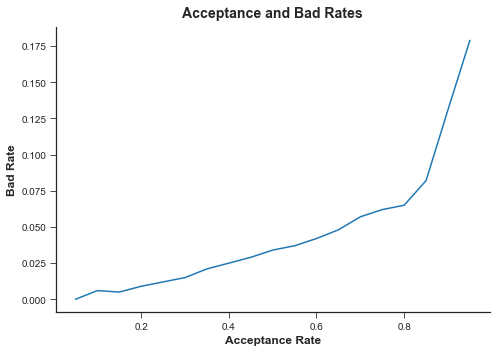

In [34]:
# Plot the strategy curve
f,ax1 = plt.subplots(1,1,)
sns.lineplot(x=strat_df['Acceptance Rate'], y=strat_df['Bad Rate'],ax=ax1)

ax1.set_xlabel('Acceptance Rate')
ax1.set_ylabel('Bad Rate')
ax1.set_title('Acceptance and Bad Rates')

sns.despine()
plt.show()


## Conclusions

- With acceptance rates above 80% the bad rate grows very fast.
- Selecting a 85% acceptance rate we see a decrease of bad rate from 21.82% to 8.2% (-39%).
- To achieve this acceptance rate the model threshold (the value of probability of a loan be considered a default) is 0.859 sugesting that this model needs calibration, wich often occours with tree algorithms.  